# Debugging the optimization 
When we ran the sweep, we noticed some nan values for our loss at certain combinations of parameters, such as N, M, n, sigma_c = 60, 30, 2, 2. Here we'll try to reproduce that and fix it 

In [1]:
from canonical_model_jax import *

In [16]:
N, n, M, sigma_c, P = 60, 2, 30, 2.0, 1000
os = OlfactorySensing(N=N, n=n, M=M, P=P, sigma_c=sigma_c)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
W_init = 1 / jnp.sqrt(os.N) * jax.random.gamma(key, a=1, shape=(M, N))
os.W = W_init 

In [17]:
rho_vectorized = jax.vmap(lambda x: compute_rho(x, tol=1e-10), in_axes=0)

In [18]:
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

Ws, ents, losses = natural_gradient_dual_space(20, W_init, os.cs, key, lambda * args: - os.log_det_sigma(*args), 1, os, phi, psi)

Step 0, Loss: nan
Step 2, Loss: nan
Step 4, Loss: nan
Step 6, Loss: nan
Step 8, Loss: nan
Step 10, Loss: nan
Step 12, Loss: nan
Step 14, Loss: nan
Step 16, Loss: nan
Step 18, Loss: nan


In [ ]:
r = self.compute_activity(W, c, key)
cov_r = jnp.cov(r) 

In [25]:
r = os.compute_activity(Ws[1], os.cs, key)

In [37]:
jnp.sum(jnp.isnan(Ws[-1]))

Array(1800, dtype=int32)

In [31]:
Ws[1]

AttributeError: module 'jax.numpy' has no attribute 'isna'

In [28]:
jnp.cov(r)

Array([[0.07619544, 0.05088393, 0.05505865, 0.05726274, 0.05730941,
        0.05517287, 0.04871783, 0.05650748, 0.05745243, 0.05095316,
        0.05325754, 0.05118238, 0.05616958, 0.05902424, 0.05921425,
        0.05260706, 0.0589228 , 0.05254591, 0.05380242, 0.05555154,
        0.05850941, 0.05283872,        nan, 0.05020191, 0.06073312,
        0.05223018, 0.06090864, 0.05041567, 0.05978591, 0.05547848],
       [0.05088393, 0.07322355, 0.04936027, 0.05156754, 0.0533361 ,
        0.05659143, 0.05842378, 0.05412857, 0.05090664, 0.05273833,
        0.05403543, 0.05521708, 0.04947584, 0.05349454, 0.04974642,
        0.05243741, 0.0552752 , 0.05746023, 0.05416445, 0.0553023 ,
        0.05322054, 0.04767809,        nan, 0.04378163, 0.05685445,
        0.05597921, 0.05598823, 0.05183756, 0.0551401 , 0.05332114],
       [0.05505865, 0.04936027, 0.07311895, 0.05860643, 0.06227387,
        0.0538874 , 0.04389363, 0.05883612, 0.05515658, 0.05684885,
        0.05626692, 0.05623648, 0.05122575, 0.

In [23]:
os.log_det_sigma(Ws[1], os.cs, key) 

Array(nan, dtype=float32)

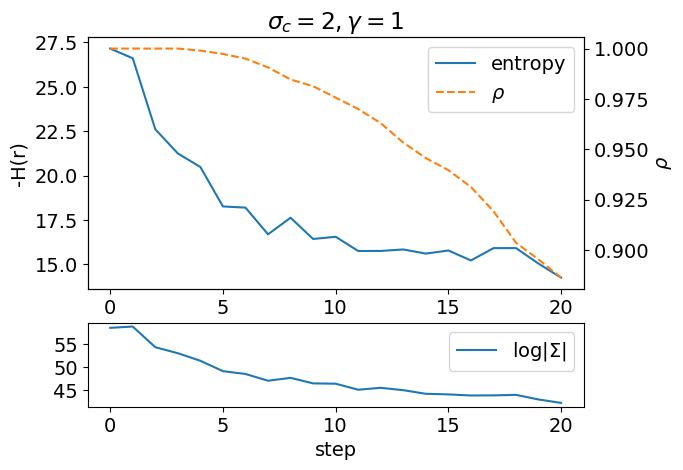

In [15]:
rhos = rho_vectorized(Ws)
fig = plot_trajectory(Ws, ents, losses, rhos, sigma_c=sigma_c, gamma=1)

I found the problem: if W is not initialized to be between 0 and 1, then $\psi(W)$ will have an nan, which will be propagated to the activity and thus to to the loss function. Easy fix: when you initialize using a gamma distribution, force it to be 0 and 1 by taking a minimum. 